In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "button_cells"

In [5]:
def clean_corrupt_images(folder_path):
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(root, file)
                try:
                    with Image.open(img_path) as img:
                        img.verify()
                except:
                    print(f"Removing corrupt image: {img_path}")
                    os.remove(img_path)

clean_corrupt_images(data_dir)

In [6]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [20]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes

In [21]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])

In [22]:
class_counts = Counter([dataset.targets[i] for i in train_data.indices])
weights = [1.0 / class_counts[dataset.targets[i]] for i in train_data.indices]
sampler = WeightedRandomSampler(weights, len(weights))

train_loader = DataLoader(train_data, batch_size=16, sampler=sampler)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

In [23]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = True  # fine-tune all layers
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

best_val_acc = 0
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [35]:
for epoch in range(20):
    # Training
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()

    train_acc = 100 * train_correct / train_total
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc)

In [39]:
model.eval()
val_loss, val_correct, val_total = 0.0, 0, 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (preds == labels).sum().item()

val_acc = 100 * val_correct / val_total
val_losses.append(val_loss / len(val_loader))
val_accuracies.append(val_acc)

print(f"Epoch [{epoch+1}/20] Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

# Save best model
if val_acc > best_val_acc:
    best_val_acc = val_acc
    torch.save(model.state_dict(), "best_model_resnet50.pth")

Epoch [20/20] Train Acc: 81.82% | Val Acc: 90.91%


In [43]:
print("Train Acc:", len(train_accuracies))
print("Val Acc:", len(val_accuracies))
print("Train Loss:", len(train_losses))
print("Val Loss:", len(val_losses))

Train Acc: 20
Val Acc: 1
Train Loss: 20
Val Loss: 1


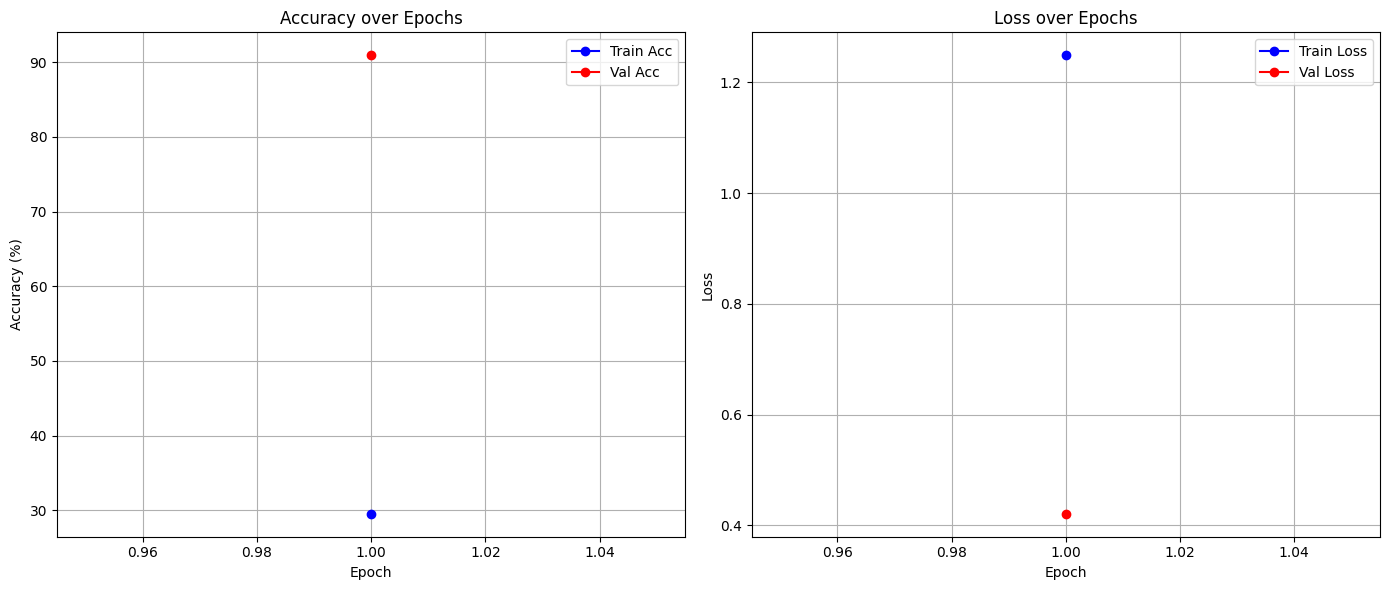

In [42]:
min_len = min(len(train_accuracies), len(val_accuracies))
epochs = range(1, min_len + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies[:min_len], 'bo-', label='Train Acc')
plt.plot(epochs, val_accuracies[:min_len], 'ro-', label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses[:min_len], 'bo-', label='Train Loss')
plt.plot(epochs, val_losses[:min_len], 'ro-', label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

   back_view       1.00      1.00      1.00         4
   side_view       1.00      0.50      0.67         2
    top_view       0.83      1.00      0.91         5

    accuracy                           0.91        11
   macro avg       0.94      0.83      0.86        11
weighted avg       0.92      0.91      0.90        11



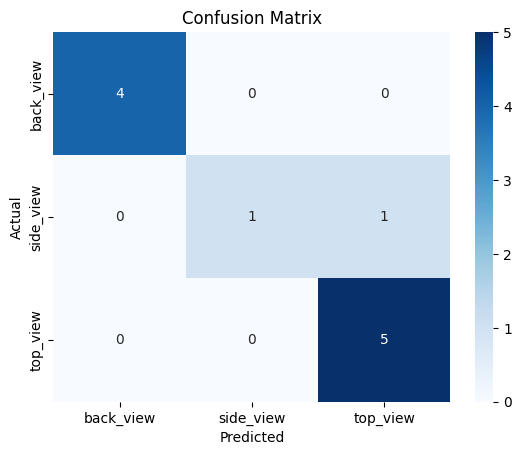

In [44]:
model.load_state_dict(torch.load("best_model_resnet50.pth"))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

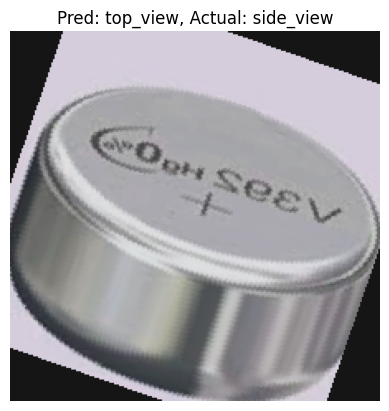

In [45]:
# Show misclassified images
import numpy as np
import matplotlib.pyplot as plt

inv_transform = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                         std=[1/0.229, 1/0.224, 1/0.225])
])

wrong = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for i in range(len(preds)):
            if preds[i] != labels[i]:
                wrong.append((inputs[i].cpu(), preds[i].cpu(), labels[i].cpu()))

# Show first 5 misclassified images
for i in range(min(5, len(wrong))):
    image, pred, label = wrong[i]
    image = inv_transform(image).permute(1, 2, 0).numpy().clip(0, 1)
    plt.imshow(image)
    plt.title(f"Pred: {class_names[pred]}, Actual: {class_names[label]}")
    plt.axis('off')
    plt.show()

In [46]:
torch.save(model.state_dict(), "button_cell_classifier.pth")

In [53]:
from PIL import Image

def predict_image(image_path, model, transform):
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(img)
        _, pred = torch.max(outputs, 1)
    return class_names[pred.item()]

# Example
test_image_path = "/content/drive/MyDrive/button_cells/back_view/15.jpg"
print("Prediction:", predict_image(test_image_path, model, transform))

Prediction: back_view


#**Phase 2**

In [4]:
import cv2
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

In [5]:
from torchvision import models
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 3)  # Change to match your class count
model.load_state_dict(torch.load("button_cell_classifier.pth", map_location='cpu'))
model.eval()

C:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
class_names = ['bottom_view', 'side_view', 'top_view']

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
import cv2
from PIL import Image
import torch
from torchvision import transforms

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load model
model.eval()  # your model must be defined and loaded
class_names = ['top_view', 'side_view', 'bottom_view']

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Crop center square
    h, w, _ = frame.shape
    min_dim = min(h, w)
    center_crop = frame[(h - min_dim)//2:(h + min_dim)//2,
                        (w - min_dim)//2:(w + min_dim)//2]

    # Convert to PIL and preprocess
    img = Image.fromarray(cv2.cvtColor(center_crop, cv2.COLOR_BGR2RGB))
    input_tensor = transform(img).unsqueeze(0)  # Add batch dim

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)
        label = class_names[pred.item()]

    # Display
    cv2.putText(frame, f"Prediction: {label}", (30, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("Button Cell Classifier", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
